## 预测泰坦尼克号乘客生还率

# 项目背景
1912年，泰坦尼克号在第一次航行中就与冰山相撞沉没，导致了大部分乘客和船员身亡。

###  我们将会探索泰坦尼克号中的部分数据来分析，乘客的哪些特征会影响他的生存率。

### 了解数据
当我们开始处理泰坦尼克号乘客数据时，会使用pandas DataFrame来加载数据。并使用 .head() 函数显示前面几项乘客数据。

In [472]:
#encoding=utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sa

In [473]:
full_data = pd.read_csv("titanic-data.csv")
full_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### 列的描述
* Survived ：是否存活（0代表否 1代表是）
* Pclass:社会阶级（1代表上层阶级，2代表中层阶级，3代表的是底层阶级）
* Name：船上乘客的名字
* Sex：船上乘客的性别
* Age：船上乘客的年龄（可能会存在NaN）
* SibSp：乘客在船上的兄弟姐妹和配偶的数量
* Parch：乘客在船上的父母以及小孩的数量
* Ticket：乘客船票的编号
* Fare：乘客为船票支付的费用
* Cabin：乘客所在船舱的编号（可能存在NaN）


###### 对于乘客的存活率感兴趣，所以我们要对乘客的存活进行预测，所以原来数据集中的Survive这个特征我们需要把它移除，单独存放一个数据集

# 数据的整理

In [474]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### 从这份数据我们可以发现，这里一共有 891 行数据，所以在中间那一列数据中看到的不是 891 个数据的，都是有缺失值的。比如年龄Age这一列，有714个非空数值，就有 891-714=177 个缺失值。又比如船舱号码 cabin，缺失值就更多了。登船码头的缺失值比较少，后面可以不用处理。

#### 对于缺失值的处理：
        cabin 在这里的缺失率已经超过了70%以上，可以考虑删除当前所在的行，但是在数据分析的时候，考虑到当前行中其他没有缺失的值可能会提供有用的信息，所以可以对缺失的值赋上一个代表缺失的值
            
        对于Age这个变量是非常的重要，有20%左右的缺失率，所以可以考虑用中位数来填充丢失的值
        
##### 用所有数据的年龄的中位数来填充丢失的年龄值

In [475]:
#查看Age列的统计值
full_data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

##### 这份数据照样是可以看到，非缺失值 count 是有 714，平均值 mean 是 29.6岁，标准差 std 是 14.5，中位数是：28。

In [476]:
#填充Age缺失值
age_median = full_data.Age.median()
full_data.Age.fillna(age_median,inplace=True)
full_data.Age.describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

#### 填充缺失值之后可以发现均值比原来低，而我们的Age的非缺失值也变成了891

#### 因为我们要进行预测的是生存率，下面我们把数据中的Survived给重新做成单独的数据表，之后分析相关特征之后和这个单独的数据表进行比较预测


#### 船舱号Cabin这一特征，缺失可能代表并没有船舱。

### 在这里为了方便后面对于年龄段的分析，在这里添加一行


In [477]:
bins = np.arange(0,80,10)
full_data["AgeGroup"] = pd.cut(full_data["Age"],bins)

survived_data = full_data['Survived']
show_data = full_data.drop(['Survived'],axis=1)
show_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(20, 30]"
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(30, 40]"
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(20, 30]"
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(30, 40]"
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(30, 40]"
5,6,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q,"(20, 30]"
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,"(50, 60]"
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,"(0, 10]"
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,"(20, 30]"
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,"(10, 20]"


##### 我们暂时不知道泰坦尼克号上的乘客是否存活，而我们要进行的预测存活的比例，如果乘客已经全部遇难了，那么我们的预测就是没有意义的，所以我们先要对所以的乘客是否遇难进行预测，才能更好的预测存活率

In [478]:
def survival_rate(data,prediction_data):
    
    if len(data) == len(prediction_data):
        return "要进行预测的数据概率是：{:.2f}%".format(((data == prediction_data).mean()) * 100)
    else:
        return "数据不匹配"
    
def prediction_no_survival_data(data):
    return pd.Series([0 for i,item in data.iterrows()])
    
no_survived_all = prediction_no_survival_data(show_data)

In [479]:
print survival_rate(survived_data,no_survived_all)

要进行预测的数据概率是：61.62%


##### 通过上面的数据可以知道不可能全部遇难,所以需要找出生存变化和数据中一些最重要的特征之间的关系。
# 问题1 是否乘客性别的特征会影响他的存活率？

In [480]:
def filter_data(data, condition):
    field, op, value = condition.split(" ")
    
    try:
        value = float(value)
    except:
        value = value.strip("\'\"")
    
    if op == ">":
        matches = data[field] > value
    elif op == "<":
        matches = data[field] < value
    elif op == ">=":
        matches = data[field] >= value
    elif op == "<=":
        matches = data[field] <= value
    elif op == "==":
        matches = data[field] == value
    elif op == "!=":
        matches = data[field] != value
    else:
        raise Exception("Invalid error")
        
    data = data[matches].reset_index(drop = True)
    return data

#key是根据哪些数组来分组，filters是过滤条件
def survival_stats(data,k,key=[],get_value = "Survived",filters = []):
    for condition in filters:
        data = filter_data(data,condition)

    if key == ["Sex","Survived"]:
        df=pd.DataFrame()
        plt.figure(figsize=(10,6))
        ax2 = plt.subplot(122)
        full_data.groupby(["Sex"])["Survived"].mean().plot(kind = k ,ax = ax2)
        
        ax1 = plt.subplot(121)
        full_data.groupby(key)[get_value].count().unstack().plot(kind = k,ax = ax1,stacked = True)

        
    elif key == ["AgeGroup","Sex"]:
        data.groupby(["AgeGroup","Sex"])["Survived"].mean().unstack().plot(kind = k)
    elif key == ["AgeGroup"]:
        data.groupby(key)[get_value].mean().plot(kind = k)
    else:
        if k == 'kde':
            data.Age[data.Embarked == "C"].plot(kind='kde')
            data.Age[data.Embarked == "S"].plot(kind='kde')
            data.Age[data.Embarked == "Q"].plot(kind='kde')
            plt.legend(("C", "S","Q"),loc='best') 
        else:
            Sex_survived_rate=(data.groupby(['Age']).sum()/data.groupby(['Age']).count())['Survived']
            Sex_survived_rate.plot()
            plt.title("Survival Statistics With Age")
        
    plt.xlabel(key)
    plt.ylabel('Number of Passengers or Percent of Passengers')
    plt.title('Passenger Survival Statistics With {} Feature'.format(key))
    plt.show()

#### 考虑一个特征进行预测 通过乘客的性别特征来进行预测

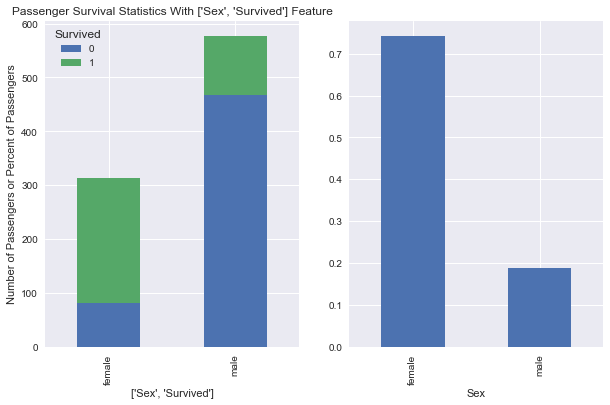

In [481]:
survival_stats(full_data, k = "bar",key = ["Sex","Survived"],get_value = "PassengerId")

#### 通过乘客的性别统计图可以看出， 在泰坦尼克号沉没的时候，大多数的男性都遇难了，而另一边，大多数的女性都存活了下来，所以可以明显的看出性别对于乘客的存活率是很有影响力

In [482]:
def prediction_survival_with_female(data):
    predictions = []
    for i,passenger in data.iterrows():
        if passenger['Sex'] == 'female':
            predictions.append(1)
        else:
            predictions.append(0)
    return pd.Series(predictions)
        
survival_with_female = prediction_survival_with_female(full_data)

#### 对女性全部生存的概率进行预测

In [483]:
print survival_rate(survived_data,survival_with_female)

要进行预测的数据概率是：78.68%


#### 从预测的结果可以看出，如果只是女性生存的概率是非常的高，那么接下来会分析可以在此概率的基础上继续增加生存率的乘客特征，从之前的分析Sex状态图可以看出在男性乘客中有少数乘客是生存的，那么我们就分析这少部分男性乘客因为什么而得以生存，我们可以通过Age特征的状态图来观看 下面显示单独的Age图和Sex&Age&Survived组合的图

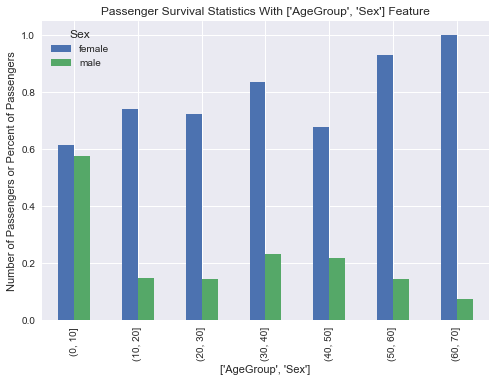

In [484]:
survival_stats(full_data, k = "bar",key = ["AgeGroup","Sex"])

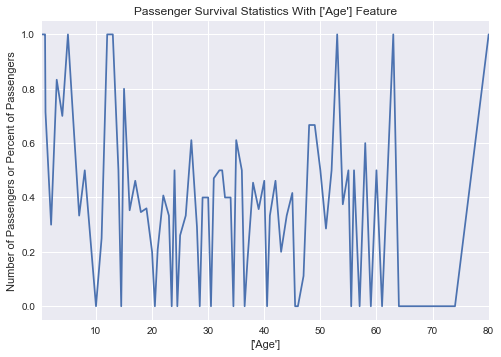

In [485]:
survival_stats(full_data, k = "bar",
               key = ["Age"])



##### 通过图形可以直观的知道在船沉没的时候，大多数年纪小于10岁的男性都存活了下来，那么大于10岁的男孩都遇难了，我们接下来预测所有女性存活并且年纪小于10岁的男性的存活概率

In [486]:
def prediction_survival_mixing_characteristics(data):
    predictions = []
    for i,passenger in data.iterrows():
        if passenger['Sex'] == 'female':
            predictions.append(1)
        elif passenger['Sex'] == 'male' and passenger['Age'] < 10:
            predictions.append(1)
        else:
            predictions.append(0)
    return pd.Series(predictions)
        
survival_mixing = prediction_survival_mixing_characteristics(full_data)

###### 对女性存活并且年纪小于10岁的男性进行预测

In [487]:
print survival_rate(survived_data,survival_mixing)

要进行预测的数据概率是：79.35%


###### 可以看出我们的预测是正确的，小于10岁的男性对于我们的预测有一定的影响
# 问题2 乘客的社会地位的特征是否会影响到他的生存率


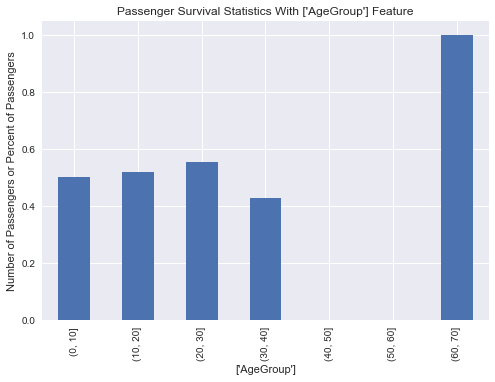

In [488]:
survival_stats(full_data, k = "bar",key = ["AgeGroup"],get_value = "Survived",filters = ["Pclass == 3", "Sex == 'female'"])

##### 从上面可以看出女性在Plcass == 3的时候在40岁——60岁之间的存活率很低，所以survived = 0

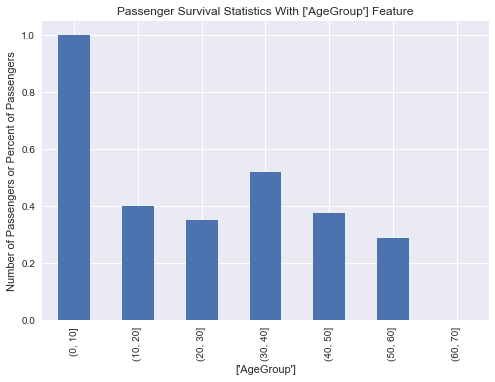

In [489]:
survival_stats(full_data, k = "bar",key = ["AgeGroup"],get_value = "Survived",filters = ["Pclass == 1", "Sex == 'male'"])

###### 对于男性乘客来说，当他的社会地位很高并且年纪在40岁以下的时候，获救概率会比较高

In [490]:
def prediction_survival_pclass(data):
    predictions = []
    for i,passenger in data.iterrows():
        if passenger['Sex'] == 'female':
            if passenger['Age'] > 40 and passenger['Age'] < 60 and passenger['Pclass'] == 3:
                predictions.append(0)
            else:
                predictions.append(1)
        else:
            if passenger['Age'] < 10:
                predictions.append(1)
            elif passenger['Age'] > 30 and passenger['Age'] < 40 and passenger['Pclass'] == 1:
                predictions.append(1)
            else:
                predictions.append(0)
    return pd.Series(predictions)

survival_pclass = prediction_survival_pclass(full_data)

###### 对社会地位比较高的乘客进行预测

In [491]:
print survival_rate(survived_data,survival_pclass)

要进行预测的数据概率是：80.47%


#### 通过上面的预测概率可以明确知道乘客的生存率与他们的社会地位有一定的关系
# 问题3 乘客的生存率是否和登船口有关系？

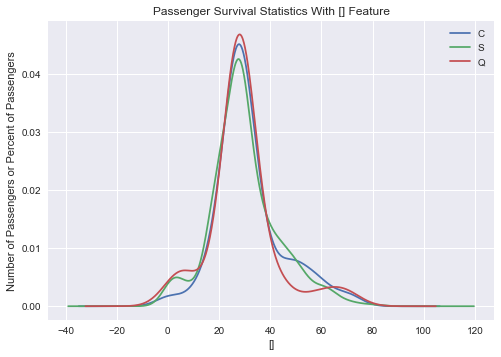

In [499]:
survival_stats(full_data, k = "kde",filters=["Sex == 'male'"])

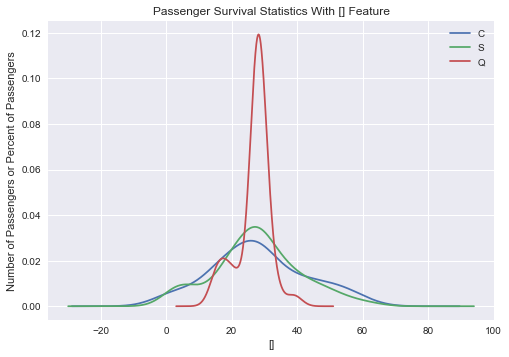

In [493]:
survival_stats(full_data, k = "kde",filters=["Sex == 'female'"])

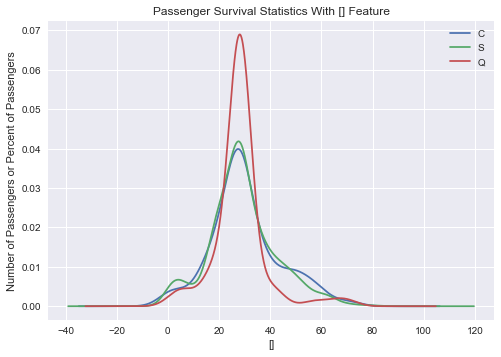

In [494]:
survival_stats(full_data, k = "kde")

#### 通过乘客与登船口的关系图可以明确的知道女性乘客在Q登船口的生存率明显很低，而男性乘客在年纪小于10岁并且在C，S登船口的生存率比较高，可以通过下面的代码来预测乘客生存率和登船口的关系概率

In [495]:
def prediction_survival_embarked(data):
    predictions = []
    for i,passenger in data.iterrows():
        if passenger['Sex'] == 'female':
            if passenger['Age'] > 40 and passenger['Age'] < 60 and passenger['Pclass'] == 3:
                predictions.append(0)
            elif passenger['Age'] > 30 and passenger['Age'] < 40 and passenger['Embarked'] == 'Q':
                predictions.append(0)
            else:
                predictions.append(1)
        else:
            if passenger['Age'] < 10:
                predictions.append(1)
            elif passenger['Age'] > 30 and passenger['Age'] < 40 and passenger['Pclass'] == 1:
                predictions.append(1)
            elif passenger['Age'] < 10 and (passenger['Embarked'] == 'C' or passenger['Embarked'] == 'S'):
                predictions.append(1)
            else:
                predictions.append(0)
    return pd.Series(predictions)

survival_embarked = prediction_survival_embarked(full_data)

In [496]:
print survival_rate(survived_data,survival_embarked)

要进行预测的数据概率是：80.70%


# 结论
###### 根据我们最后的预测概率可以得出乘客的获救率相关因素：
* 性别： 女性高于男性
* 年龄： 儿童大于成人，成年人略高于老年人
* 舱位： 一等舱大于其他舱位

我们使用的样本数据中包含了891人，平均年龄约为 30 岁，标准差 15 岁，最小年龄为 0.42，最大年龄 80。而通过上述的分析，得出生存率儿童大于成人，成年人略高于老年人，在这次的事故中“尊老爱幼”没有很好的体现出来，而对于仓位来说一等舱大于其他舱位，对于性别来说的话，女性的生存率远远大于男性的生存率，这可能就是西方国家的“Lady first”的体现

另外处理数据缺失值Age的时候，可能中位数的方式会导致实际的预测生存率不够准确

### 分析限制讨论
这次分析的数据并不是所有的数据，只是样本数据，根据资料，泰坦尼克号共有乘客2224人，如果本次分析的数据集是从2224人中随机选出，根据中心极限定理，该样本也足够大，分析结果有代表性；如果不是随机选出，那么分析结果就不可靠了。

对于实际因素来说，可能还会有其他的因素影响用户的生存率，比如说：生存率是否和乘客的国际有关？乘客是否会游泳？乘客的身体是否健康等？